In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.impute import KNNImputer

In [2]:
# open the file and read its contents
with open('logins.json', 'r') as file:
    raw_data = json.load(file)
print(raw_data.keys())    
    
# convert it to pandas dataframe:
df = pd.DataFrame(raw_data)
df['login_time'] = pd.to_datetime(df['login_time'])
# df.set_index('login_time', inplace=True)  # Set as index
# df.index = pd.to_datetime(df.index)
# check the data
df.head()

dict_keys(['login_time'])


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# resample and count logins every 15 minutes
rsmpl = df.resample('15T', on='login_time').size()
print(rsmpl.head())
df_rsmpl = pd.DataFrame(rsmpl)
df_rsmpl.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64


,0
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [4]:
df_rsmpl.rename(columns={0: "15_login_time"}, inplace=True)

In [5]:
df_rsmpl.head()

,15_login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<Figure size 720x432 with 0 Axes>

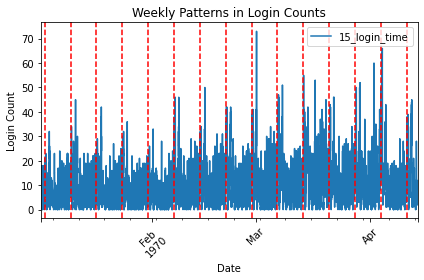

In [6]:
# plotting the resampled data

plt.figure(figsize=(10, 6))
df_rsmpl.plot(kind='line', linestyle='-')

# Adding vertical lines at the start of each week
min_date, max_date = df_rsmpl.index.min(), df_rsmpl.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

plt.title('Weekly Patterns in Login Counts')
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In the data, we observe a seasonal pattern characterized by periodic peaks. To gain a deeper insight into this pattern, we plotted vertical lines on days when current_date.weekday() == 5, with the number 5 representing Friday. This visualization reveals that all observed peaks align with the weekends, suggesting a significant increase in activity or demand during these days.

In [7]:
y = df_rsmpl['15_login_time']
y.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: 15_login_time, dtype: int64

In [8]:
y.describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: 15_login_time, dtype: float64

In [9]:
df_rsmpl.head()

,15_login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


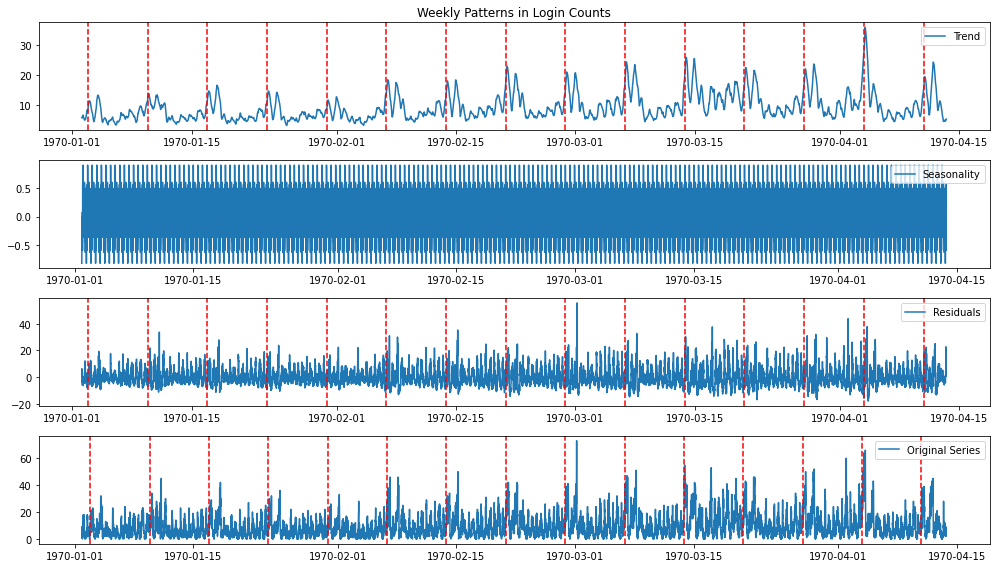

In [10]:
import statsmodels.api as sm
# Specify the frequency of your data
y.index.freq = '15T'  # '15T' stands for frequency of the data
# Decomposing the time series again using a multiplicative model
decomposition_sm = sm.tsa.seasonal_decompose(y, model='additive', period=52)

# Plotting the decomposed components
plt.figure(figsize=(14, 8))

# Trend component
plt.subplot(411)
plt.plot(decomposition_sm.trend, label='Trend')
plt.legend(loc='best')
plt.title('Weekly Patterns in Login Counts')

min_date, max_date = df_rsmpl.index.min(), df_rsmpl.index.max()
current_date = min_date
while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

# Seasonal component
plt.subplot(412)
plt.plot(decomposition_sm.seasonal, label='Seasonality')
plt.legend(loc='best')

# Residual component
plt.subplot(413)
plt.plot(decomposition_sm.resid, label='Residuals')
plt.legend(loc='best')
current_date = min_date
while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

# Original series
plt.subplot(414)
plt.plot(y, label='Original Series')
plt.legend(loc='best')
plt.tight_layout()
current_date = min_date
while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

plt.show()

## Observation:
The analysis of the time series decomposition reveals a daily pattern, with the highest activity consistently occurring in the afternoons. On a weekly basis, the most pronounced peaks are observed on Friday and Saturday afternoons. However, there is no discernible seasonal pattern in this time series.

Let's examine the seasonality in more detail by plotting vertical lines at specific times each week to highlight cyclical patterns.

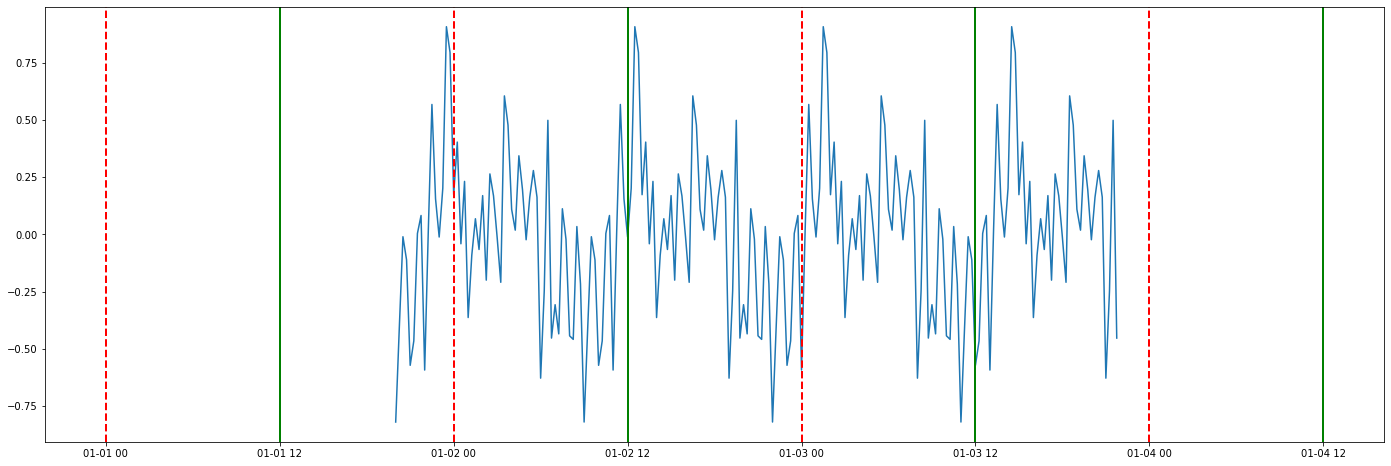

In [11]:
plt.figure(figsize=(24, 8))
# Choose a limit
limit_to_plot = 200
plt.plot(decomposition_sm.seasonal[:limit_to_plot], label='Seasonality')

# # Add vertical lines for each day
# current_date = min_date
# while current_date <= df_rsmpl.index[limit_to_plot]:
#     plt.axvline(x=current_date, color='red', linestyle='--')
#     current_date += pd.Timedelta(days=1)
# Find unique days
unique_days = df['login_time'].dt.floor('D').unique()[:int(limit_to_plot/50)]

# Add vertical lines for each day
for day in unique_days:
    plt.axvline(day, color='red', linestyle='--', lw=2)

# Add another vertical line for each day at 11:00 AM
for day in unique_days:
    eleven_am = pd.Timestamp(day).replace(hour=12, minute=0, second=0)
    plt.axvline(eleven_am, color='Green', linestyle='-', lw=2)

# Plotting your existing data (replace with your actual plot code)
# plt.plot(df['datetime'], [some data])

plt.show()


The pattern we observe is not recurring on a weekly basis. To gain further insights, let's explore this using the autocorrelation function.

In the graph above, the green line marks 11:00 am and the red line indicates the 

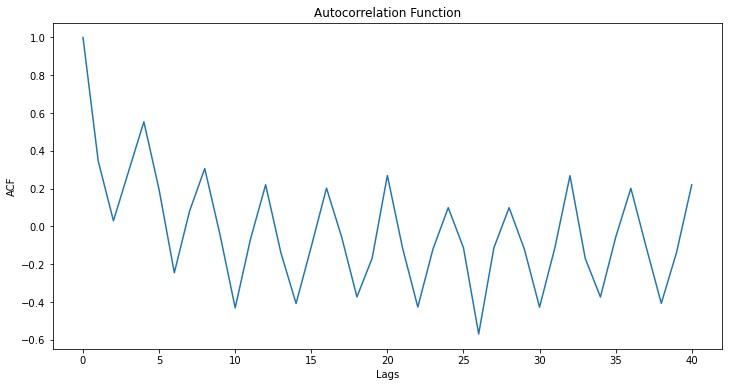

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf


# Calculate autocorrelation
lag_acf = acf(decomposition_sm.seasonal, nlags=40)
plt.figure(figsize=(12, 6))
plt.plot(lag_acf)
plt.title('Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Further analysis like Fourier analysis can be conducted based on the nature of your data


The ACF diminishes to zero and fluctuates around this level, suggesting a cyclic pattern in the original data. To determine the precise frequency, we can employ the Fast Fourier Transform (FFT).

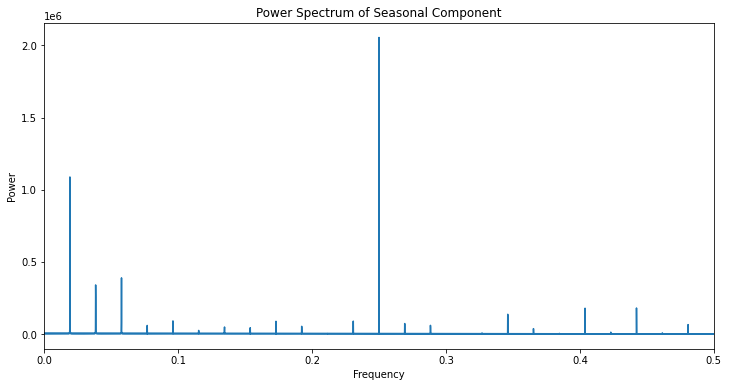

The most dominant frequency is at: -0.25 cycles/unit time
This corresponds to a peak period (seasonality frequency) of: 4.0 time units


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming decomposition_sm is your decomposition result with a seasonal component
seasonal_component = decomposition_sm.seasonal.dropna()  # Remove any NaN values

# Perform Fast Fourier Transform (FFT)
fft_result = np.fft.fft(seasonal_component)
frequencies = np.fft.fftfreq(len(fft_result))

# Compute the power spectrum (squared magnitude of the FFT)
power = np.abs(fft_result)**2

# Find the peak frequency
peak_freq = frequencies[power.argmax()]
peak_period = abs(1 / peak_freq)

# Plot the power spectrum
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power)
plt.title('Power Spectrum of Seasonal Component')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xlim([0, 0.5])  # Limiting x-axis for better visibility
plt.show()

print(f"The most dominant frequency is at: {peak_freq} cycles/unit time")
print(f"This corresponds to a peak period (seasonality frequency) of: {peak_period} time units")


The Fast Fourier Transform (FFT) analysis of your data identifies the most dominant frequency at approximately 0.25 cycles per unit time, which translates to a peak period, or seasonality frequency, of 4.0 time units. This indicates that the primary cyclic pattern in your data repeats every 4 units of time.

# Part 2:


### 1) Key Measure of Success

**Metric Choice:** The most appropriate metric would be the **increase in the number of cross-city trips** made by driver partners. 

**Why This Metric:**
- **Direct Relevance:** Directly measures the toll reimbursement's impact on driver behavior.
- **Quantifiable:** Easily tracked and quantified through trip records.
- **Comparability:** Facilitates a clear before-and-after comparison.

### 2) Experiment Design

#### a) Implementation

**Control and Treatment Groups:**
- **Control Group:** Driver partners not offered toll reimbursement.
- **Treatment Group:** Driver partners offered toll reimbursement.

**Duration:** Run the experiment for a sufficient duration, typically a few weeks to months.

**Data Tracking:** Accurately record all trips, focusing on cross-city trips.

#### b) Statistical Tests

**1. T-Test:**
- **Purpose:** Compare means of cross-city trips between control and treatment groups.
- **Assumption:** Normal distribution of cross-city trip numbers.

**2. Chi-Square Test:**
- **Purpose:** Test significance in proportions of categorical data (e.g., whether a driver made a cross-city trip).

**3. Regression Analysis:**
- **Purpose:** Control for other influencing variables (time of day, day of the week).

#### c) Interpreting Results and Recommendations

**Interpretation:**
- **Effective:** Suggests toll reimbursement is positively influencing behavior.
- **Ineffective:** Indicates other barriers might be more significant.

**Recommendations:**
- **Effective:** Propose broad implementation of toll reimbursement.
- **Ineffective:** Investigate other barriers and consider alternative strategies.

**Caveats:**
- **External Factors:** Be aware of other influencing factors like city events, weather, or economic changes.
- **Behavioral Adaptation:** Monitor for novelty effects in behavior change.

**Follow-up Analysis:**
- **Long-Term Trends:** Observe if behavior changes are sustained.
- **Cost-Benefit Analysis:** Evaluate the financial feasibility against the benefits.


# Part 3:

In [14]:

# open the file and read its contents
with open('ultimate_data_challenge.json', 'r') as file:
    raw_data_ultimate = json.load(file)
print(len(raw_data_ultimate))    

# convert it to pandas dataframe:
df_ultimat = pd.DataFrame(raw_data_ultimate)

df_ultimat.head()

50000


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# ToDo:

Add a new feature, lenght of membership:

last_trip_date - signup_date

# Dealing with missing values:

In [15]:
df_ultimat['last_trip_date'].unique().shape

(182,)

In [16]:
df_ultimat.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [17]:
df_ultimat['phone'].fillna(df_ultimat['phone'].mode()[0], inplace=True)


imputer = KNNImputer(n_neighbors=5)
df_ultimat[['avg_rating_of_driver', 'avg_rating_by_driver']] = imputer.fit_transform(df_ultimat[['avg_rating_of_driver', 'avg_rating_by_driver']])


In [18]:
df_ultimat.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

# Exploratory Data Analysis (EDA):

Let's find out what are the first and last days in the data set (last_day): 

In [19]:
# find the first day 
first_day = df_ultimat['last_trip_date'].unique().min()

In [20]:
# define the last day (current day)
last_day = datetime.strptime(df_ultimat['last_trip_date'].unique().max(), '%Y-%m-%d')

In [21]:
print(last_day)
# Threshould to be considered active
active_threshold = 30

active_date = last_day - timedelta(days=active_threshold)# subtract active_thresold from last_day to get active_date
print(active_date)

2014-07-01 00:00:00
2014-06-01 00:00:00


Now let's plot the last_trip_date histogram. 

In [22]:
# Convert date column from string to datetime
df_ultimat['last_trip_date'] = pd.to_datetime(df_ultimat['last_trip_date'])
df_ultimat['signup_date'] = pd.to_datetime(df_ultimat['signup_date'])


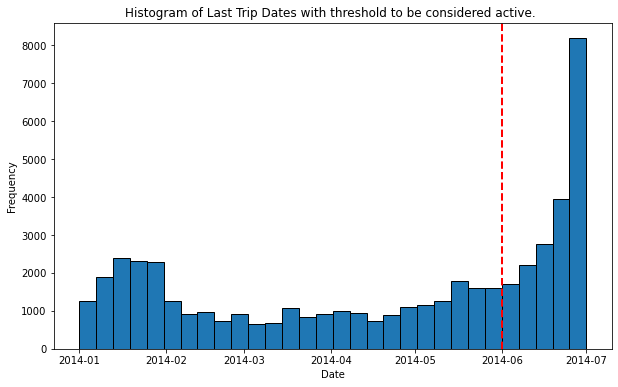

In [23]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_ultimat['last_trip_date'], bins=30, edgecolor='black')
plt.axvline(active_date, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Last Trip Dates with threshold to be considered active. ')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

The bars to the right of the red line represent active users, while those to the left signify non-active users. This concept is utilized to engineer the target variable 'y', where 'y' is assigned a value of 1 for active users and 0 for non-active users.

In [24]:
df_ultimat['y'] = (df_ultimat['last_trip_date'] >= active_date).astype(int)


In [25]:
df_ultimat['y'].head()

0    1
1    0
2    0
3    1
4    0
Name: y, dtype: int32

In [26]:
df_ultimat['y'].describe()

count    50000.000000
mean         0.376080
std          0.484405
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: y, dtype: float64

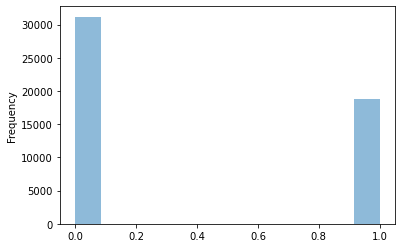

In [27]:
ax = df_ultimat['y'].plot.hist(bins=12, alpha=0.5)

Note: We have class imbalnce problem here. 

In [28]:
df_ultimat.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,y
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Let's look at the historgram of the numeric columns:

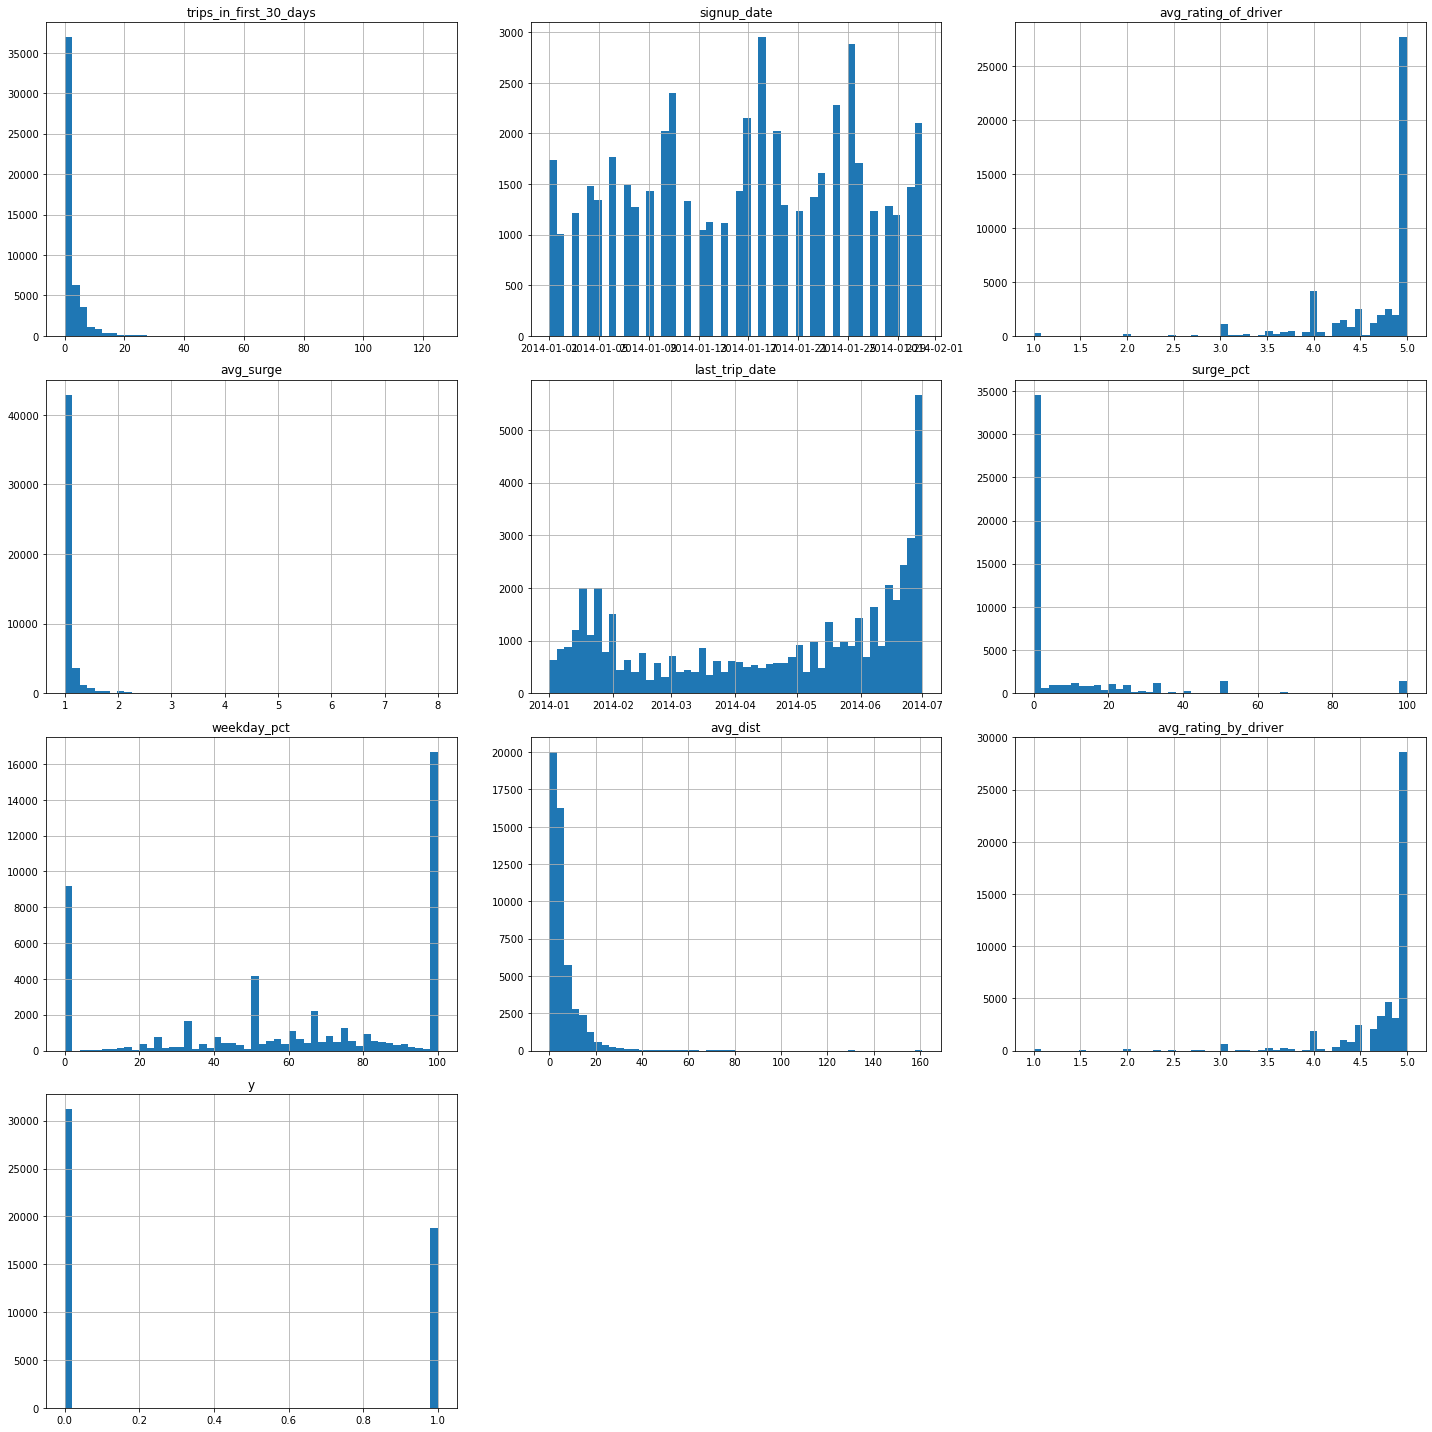

In [29]:
# Plot histograms for the numeric columns
df_ultimat.hist(figsize=(20, 20), bins=50)
plt.tight_layout()
plt.show()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


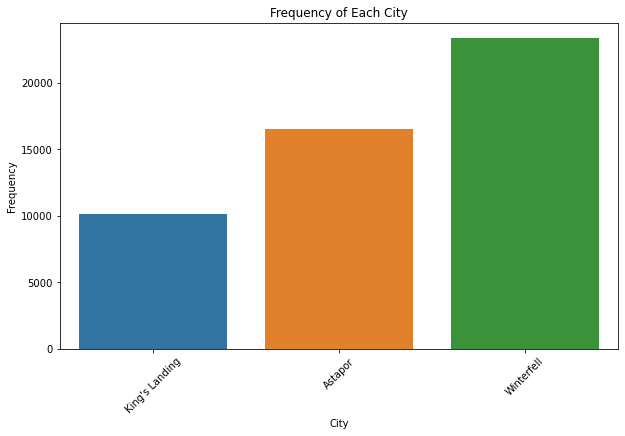

In [30]:
# Count the frequency of each city
city_counts = df_ultimat['city'].value_counts()
print(city_counts)
# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='city', data=df_ultimat)

plt.title('Frequency of Each City')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the city names for better visibility
plt.show()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


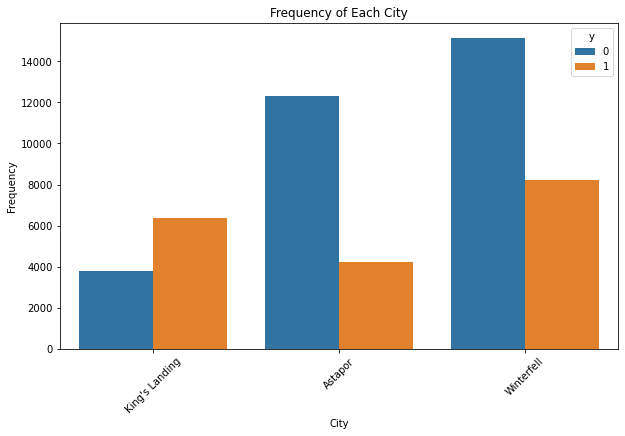

In [31]:
# Count the frequency of each city
city_counts = df_ultimat['city'].value_counts()
print(city_counts)
# Plotting the bar chart
plt.figure(figsize=(10, 6))

sns.countplot(x='city', hue='y', data=df_ultimat)
plt.title('Frequency of Each City')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the city names for better visibility
plt.show()

This graph illustrates that in King's Landing, the number of active users surpasses the number of inactive users. Conversely, in the other two cities, inactive users outnumber active ones.

In [32]:
df_ultimat.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,y
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [33]:
df_ultimat['y'].head()


0    1
1    0
2    0
3    1
4    0
Name: y, dtype: int32

# Computing Correlation Matrix: 

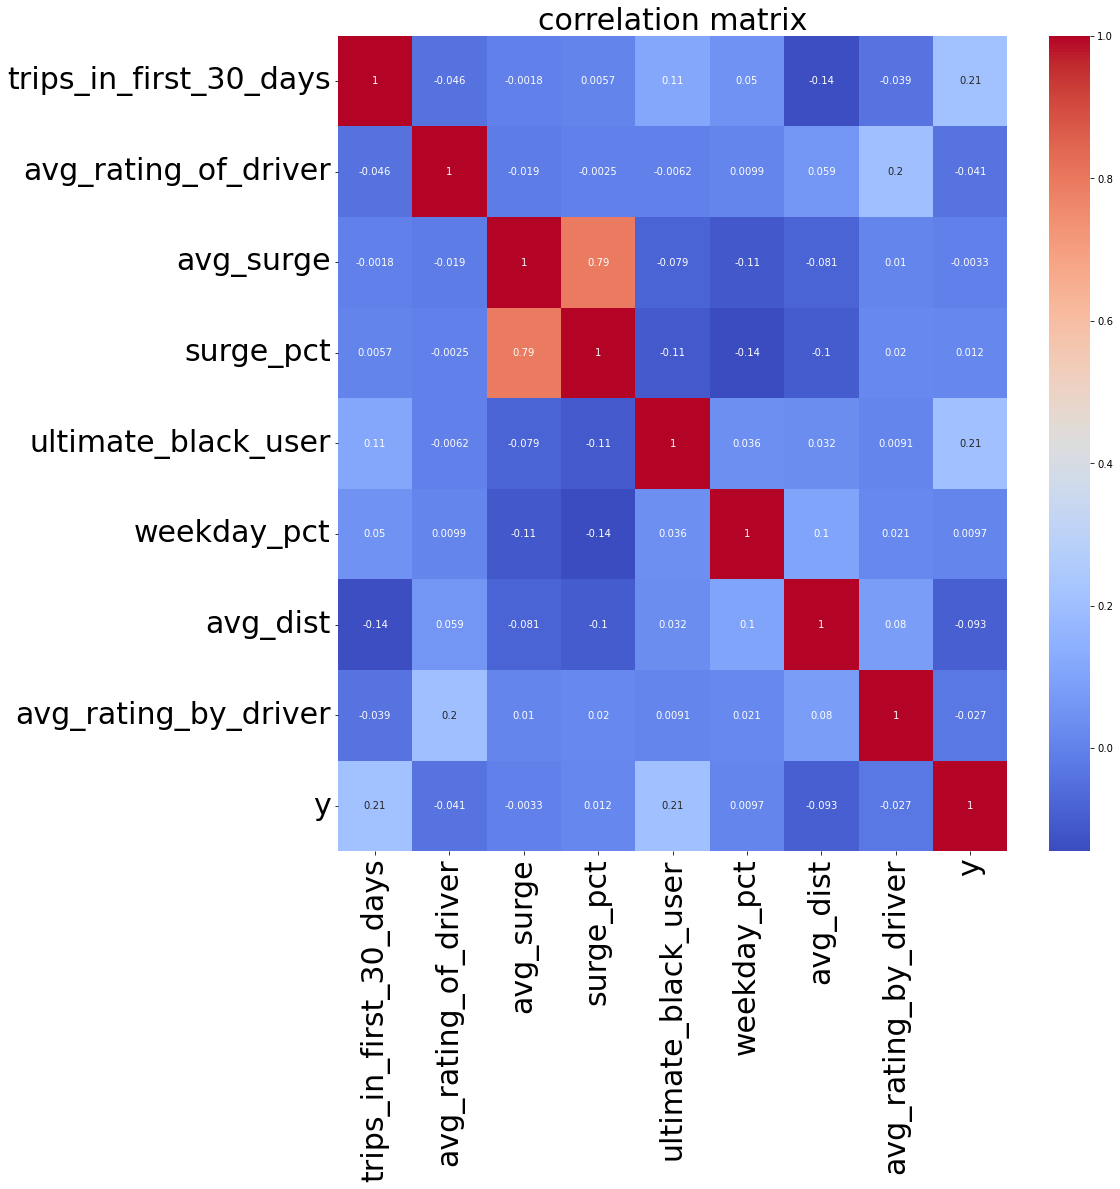

In [34]:
corr_matrix = df_ultimat.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('correlation matrix', fontsize=30)
# Customize tick size
plt.xticks(fontsize=30)  # Increase xtick size
plt.yticks(fontsize=30)  # Increase ytick size
plt.show()

The data suggests a strong correlation between avg_surge and surge_pct. To simplify the model, it would be prudent to remove one of these variables or create a whole new variable. We will come back to this in feature engineering section.

In [35]:
# df_ultimat.drop(['avg_surge'], inplace=True, axis=1)

In [36]:
df_ultimat.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,y
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


# Feature engineering: 

## Date Feature Extraction from signup_date:

Month of Signup: The month in which the user signed up may be influential, as user behavior can vary with seasons or months (e.g., January vs. July).

Weekday of Signup: The day of the week can also be a valuable feature, distinguishing between users who sign up on weekdays versus weekends.

Signup Day: Extracting the day (1-31) might reveal trends (e.g., more signups at the beginning or end of the month).

In [37]:
df_ultimat['signup_month'] = pd.to_datetime(df_ultimat['signup_date']).dt.month
df_ultimat['signup_weekday'] = pd.to_datetime(df_ultimat['signup_date']).dt.weekday
df_ultimat['signup_day'] = pd.to_datetime(df_ultimat['signup_date']).dt.day


# Converting date strings to datetime objects
df_ultimat['signup_date'] = pd.to_datetime(df_ultimat['signup_date'])
df_ultimat['last_trip_date'] = pd.to_datetime(df_ultimat['last_trip_date'])

# Calculating the length of membership in days
df_ultimat['length_of_membership'] = (df_ultimat['last_trip_date'] - df_ultimat['signup_date']).dt.days


# droping the signup_date 
df_ultimat.drop(['signup_date', 'last_trip_date'], inplace=True, axis=1)


## User Engagement Features:

Average Distance per Trip: Indicates the user's average trip length. It could be insightful to see if shorter or longer trips are associated with different outcomes.
Surge Multiplier Interaction: Interactions between avg_surge and surge_pct could highlight patterns in user sensitivity to pricing.

In [38]:
# df_ultimat['avg_dist_per_trip'] = df_ultimat['avg_dist'] / df_ultimat['trips_in_first_30_days']
df_ultimat['surge_interaction'] = df_ultimat['avg_surge'] * df_ultimat['surge_pct']


df_ultimat.drop([
#     'avg_dist', 
#     'trips_in_first_30_days', 
    'avg_surge', 
    'surge_pct' ], inplace=True, axis=1)

## Categorical Variable Expansion:

City and Phone Type: One-hot encoding of categorical variables like 'city' and 'phone' can help the model in utilizing these features effectively.

In [39]:
df_ultimat = pd.get_dummies(df_ultimat, columns=['city', 'phone'], drop_first=True)


In [40]:
df_ultimat.head()

,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,y,signup_month,signup_weekday,signup_day,length_of_membership,surge_interaction,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,True,46.2,3.67,5.0,1,1,5,25,143,16.940,1,0,1
1,0,5.0,False,50.0,8.26,5.0,0,1,2,29,96,0.000,0,0,0
2,3,4.3,False,100.0,0.77,5.0,0,1,0,6,1,0.000,0,0,1
3,9,4.6,True,80.0,2.36,4.9,1,1,4,10,170,22.800,1,0,1
4,14,4.4,False,82.4,3.13,4.9,0,1,0,27,47,14.042,0,1,0


### Binary Conversion of 'ultimate_black_user':
If not already in a binary format, convert the 'ultimate_black_user' field to a binary indicator (0 or 1).

In [41]:
df_ultimat['ultimate_black_user'] = df_ultimat['ultimate_black_user'].astype(int)


In [42]:
df_ultimat.isnull().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
y                         0
signup_month              0
signup_weekday            0
signup_day                0
length_of_membership      0
surge_interaction         0
city_King's Landing       0
city_Winterfell           0
phone_iPhone              0
dtype: int64

In [43]:
df_ultimat.head()

,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,y,signup_month,signup_weekday,signup_day,length_of_membership,surge_interaction,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1,46.2,3.67,5.0,1,1,5,25,143,16.940,1,0,1
1,0,5.0,0,50.0,8.26,5.0,0,1,2,29,96,0.000,0,0,0
2,3,4.3,0,100.0,0.77,5.0,0,1,0,6,1,0.000,0,0,1
3,9,4.6,1,80.0,2.36,4.9,1,1,4,10,170,22.800,1,0,1
4,14,4.4,0,82.4,3.13,4.9,0,1,0,27,47,14.042,0,1,0


### Variance Inflation Factor (VIF):



In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_ultimat.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_ultimat.values, i) for i in range(len(df_ultimat.columns))]

print(vif_data)

                   feature         VIF
0   trips_in_first_30_days    1.077872
1     avg_rating_of_driver    1.055714
2      ultimate_black_user    1.069929
3              weekday_pct    1.098813
4                 avg_dist    1.060697
5     avg_rating_by_driver    1.058828
6                        y    2.805829
7             signup_month  176.943542
8           signup_weekday    1.072757
9               signup_day    1.031838
10    length_of_membership    2.627303
11       surge_interaction    1.037370
12     city_King's Landing    1.404189
13         city_Winterfell    1.322519
14            phone_iPhone    1.055955


The Variance Inflation Factor (VIF) results for your features indicate that most of your variables do not have significant multicollinearity issues, except for signup_month, which has a VIF of 176.9. This is well above the common threshold values of 5 or 10, suggesting a high degree of multicollinearity.

Interpretation and Actions:
High VIF for signup_month:

This suggests that signup_month is highly linearly correlated with other variables in your dataset.
It's possible that signup_month is collinear with signup_weekday or signup_day, as all these features are derived from the signup_date.
Low to Moderate VIF for Other Features:

The VIF values for other features are well within acceptable limits, indicating that they don't have serious multicollinearity concerns.

In [45]:
df_ultimat.drop(['signup_month'], axis=1, inplace=True)

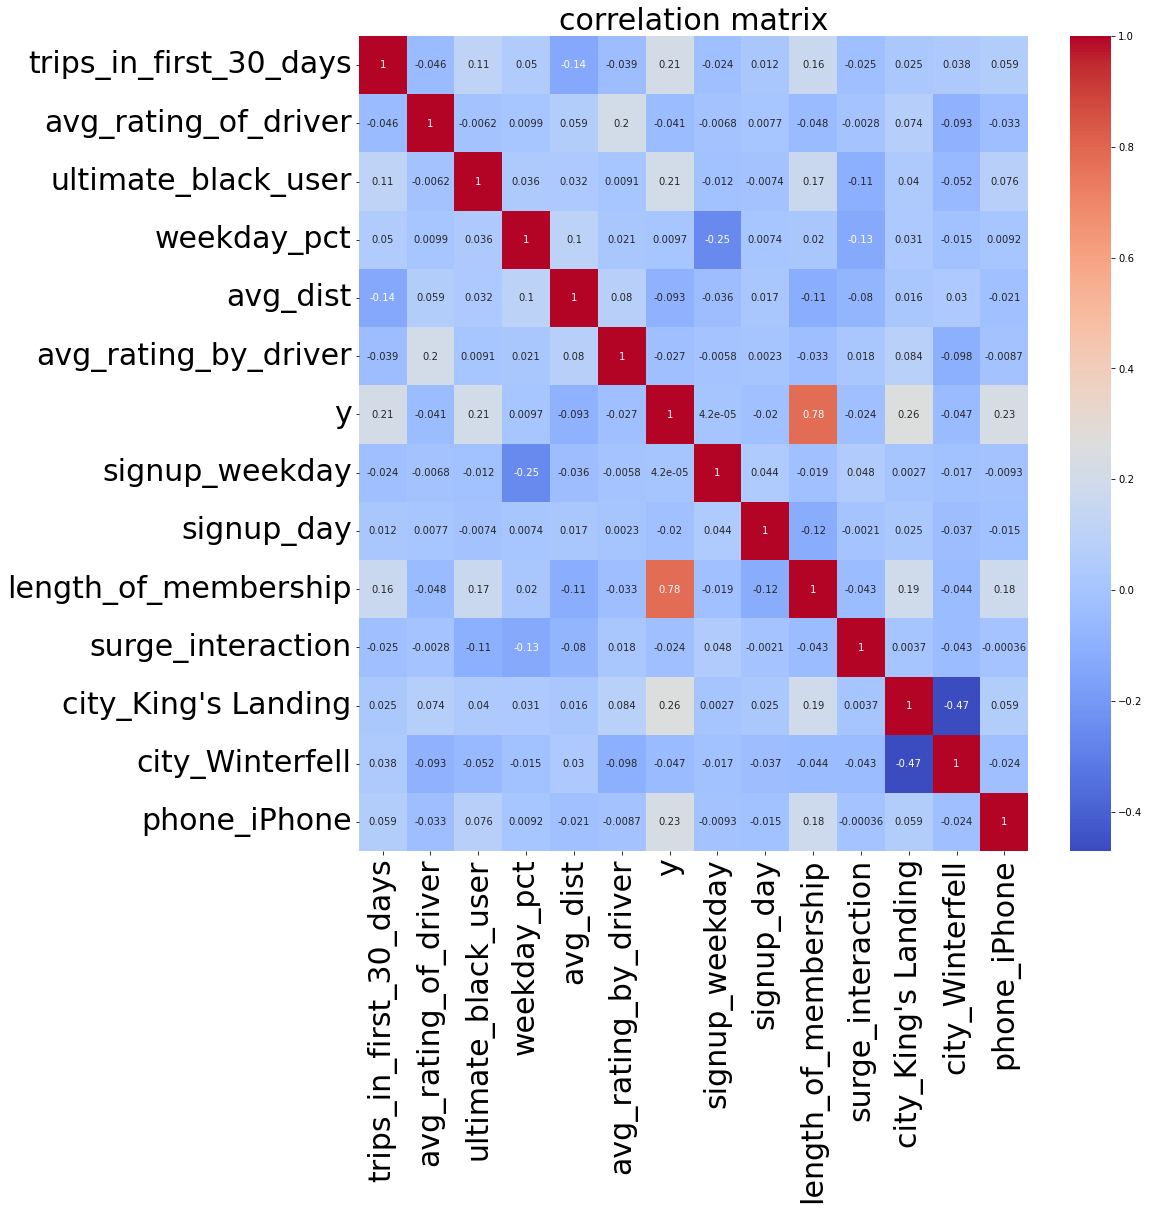

In [46]:
corr_matrix = df_ultimat.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('correlation matrix', fontsize=30)
# Customize tick size
plt.xticks(fontsize=30)  # Increase xtick size
plt.yticks(fontsize=30)  # Increase ytick size
plt.show()

## Correlation Analysis Summary

The correlation matrix above provides valuable insights into the relationships between various user-related features in our dataset. Below are some key takeaways:

- **Trips in First 30 Days**: There is a strong positive correlation with the target variable `y` (0.210463), suggesting that users taking more trips in their initial 30 days show a pattern captured by `y`. A notable negative correlation with `avg_dist` (-0.136329) indicates that frequent early users tend to make shorter trips.

- **Average Rating of Driver and By Driver**: These variables are positively correlated (0.202901), indicating a mutual appreciation in ratings between drivers and users. The negative correlation of `avg_rating_of_driver` with `city_Winterfell` (-0.092981) might suggest regional differences in rating behavior.

- **Ultimate Black User Status**: Being an ultimate black user correlates positively with `y` (0.205002) and `length_of_membership` (0.165035). This points to a possible association between subscription to premium services, longer membership duration, and the behavior represented by `y`.

- **Weekday Percentage (`weekday_pct`)**: The negative correlation with `signup_weekday` (-0.253798) could reflect different usage patterns based on the weekday of signup. 

- **Average Distance (`avg_dist`)**: Shows an inverse relationship with both `trips_in_first_30_days` and `length_of_membership`. Users traveling longer distances tend to have fewer trips and shorter membership durations.

- **Target Variable `y`**: Exhibits strong positive correlations with `length_of_membership` (0.778522) and `city_King's Landing` (0.262284), indicating these features' significant impact on the outcome variable.

- **Geographical Influence**: The binary variables `city_King's Landing` and `city_Winterfell` show a strong negative correlation (-0.471555), highlighting the exclusive nature of these categories. The positive correlation of `city_King's Landing` with `y` suggests a geographical influence on the outcome.

- **Device Type (`phone_iPhone`)**: iPhone users show distinctive patterns, evidenced by their positive correlations with `y` (0.225464) and `ultimate_black_user` (0.075836).

In conclusion, this correlation analysis sheds light on the interplay between various user behaviors, preferences, and demographic factors. It is crucial in guiding further data exploration, feature engineering, and model development stages of our analysis.


In [47]:
df_ultimat.head()

,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,y,signup_weekday,signup_day,length_of_membership,surge_interaction,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1,46.2,3.67,5.0,1,5,25,143,16.940,1,0,1
1,0,5.0,0,50.0,8.26,5.0,0,2,29,96,0.000,0,0,0
2,3,4.3,0,100.0,0.77,5.0,0,0,6,1,0.000,0,0,1
3,9,4.6,1,80.0,2.36,4.9,1,4,10,170,22.800,1,0,1
4,14,4.4,0,82.4,3.13,4.9,0,0,27,47,14.042,0,1,0


## Data Splitting
Before training models, split your dataset into a training set and a testing set. This will allow you to train your model on one subset of the data and then test its performance on a separate subset.

In [48]:
from sklearn.model_selection import train_test_split

# y has been calculated before
y = df_ultimat['y']
X = df_ultimat.drop(['y'], axis=1)




In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection:
#### Logistic Regression

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],               # Type of regularization
    'solver': ['liblinear', 'saga']        # Solver
}

# Instantiate Logistic Regression model
logreg = LogisticRegression()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\rasna\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rasna\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

#### Model Evaluation


In [51]:
# Assuming grid_search is your GridSearchCV object
best_model = grid_search.best_estimator_

# You can also view the best parameters like this:
best_params = grid_search.best_params_
print("Best parameters found:", best_params)



Best parameters found: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [52]:
# Assuming 'best_model' is your tuned Logistic Regression model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.9981
Precision: 0.9968304278922345
Recall: 0.9981486379264745
F1 Score: 0.9974890973965905


In [54]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


ROC-AUC Score: 0.9999860934142364


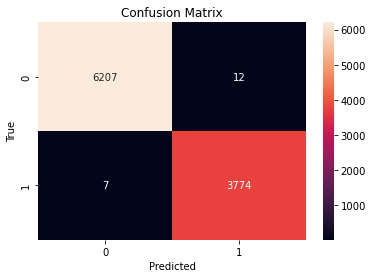

In [55]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


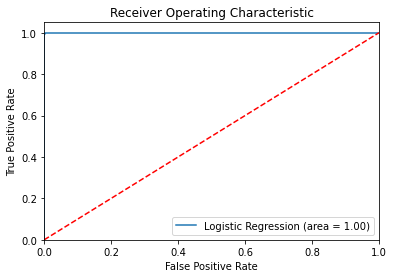

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [57]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6219
           1       1.00      1.00      1.00      3781

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Decision Trees
Pros: Easy to interpret, can handle non-linear relationships.
Cons: Prone to overfitting.
Usage: Good for understanding the decision-making process.

In [58]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')



In [59]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=2)

In [60]:
best_dt = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best parameters found:", best_params)


Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [61]:
y_pred = best_dt.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6219
           1       1.00      1.00      1.00      3781

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [62]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


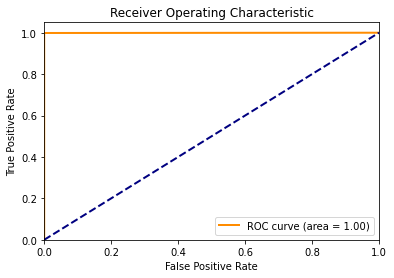

In [63]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [64]:
import pandas as pd

# Assuming 'best_dt' is your trained Decision Tree model
feature_importances = best_dt.feature_importances_

# Create a pandas series to visualize the importances
features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

print(features)


length_of_membership      0.883079
signup_day                0.109405
signup_weekday            0.006688
weekday_pct               0.000633
trips_in_first_30_days    0.000108
city_King's Landing       0.000086
avg_rating_of_driver      0.000000
ultimate_black_user       0.000000
avg_dist                  0.000000
avg_rating_by_driver      0.000000
surge_interaction         0.000000
city_Winterfell           0.000000
phone_iPhone              0.000000
dtype: float64


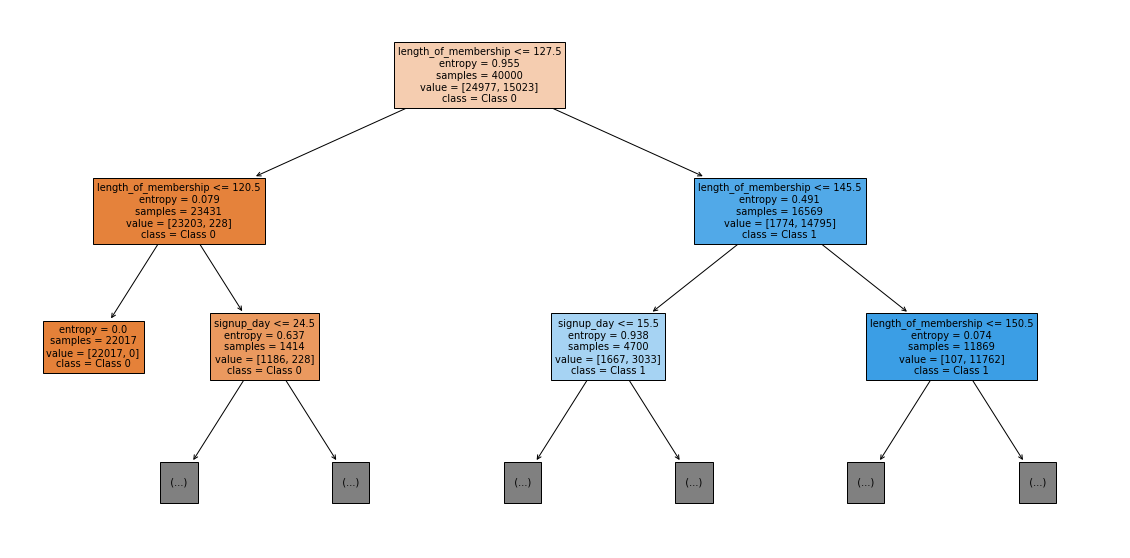

In [65]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  # Increase figure size for better readability
plot_tree(best_dt, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'], filled=True, max_depth=2)  # Reduced depth
plt.show()



## Random Forest: 

Key Advantages


Robustness: Random Forest is less prone to overfitting compared to individual decision trees due to its ensemble nature.

Handling Non-linear Data: It can handle non-linear relationships between features and the target variable.

Feature Importance: Provides insights into which features are most influential in predicting the target variable.

### Implementing Random Forest


Let's implement a Random Forest model with Scikit-Learn:

In [66]:
from sklearn.ensemble import RandomForestClassifier


In [67]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


In [68]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


In [69]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\rasna\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
309 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rasna\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rasna\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\rasna\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\rasna\anaconda3\lib\site-packa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [70]:
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best parameters found:", best_params)


Best parameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [71]:
y_pred_best_rf = best_rf.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))


Accuracy on Test Set: 0.993
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6219
           1       0.99      0.99      0.99      3781

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Model Performance Evaluation

The RandomForestClassifier's performance on the test set is summarized below:

#### Overall Accuracy
- **Accuracy: 99.3%**  
  The model accurately predicts the class of an instance 99.3% of the time, indicating an exceptionally high overall performance.

#### Precision and Recall for Class 0 (Label 0):
- **Precision: 99%**  
  Of all instances predicted as class 0, 99% actually belong to class 0. This high precision indicates a low false positive rate for class 0.
- **Recall: 99%**  
  The model correctly identifies 99% of all actual class 0 instances. This high recall rate suggests that the model is effective in detecting class 0 instances.

#### Precision and Recall for Class 1 (Label 1):
- **Precision: 99%**  
  For instances predicted as class 1, 99% genuinely are class 1. This demonstrates the model's accuracy in classifying class 1 instances.
- **Recall: 99%**  
  The model successfully identifies 99% of actual class 1 instances, indicating a high ability to detect class 1 instances without many false negatives.

#### F1-Score:
- **Class 0: 0.99**  
  The F1 score for class 0 is 0.99, suggesting an excellent balance between precision and recall for this class.
- **Class 1: 0.99**  
  Similarly, a F1 score of 0.99 for class 1 indicates an outstanding balance between precision and recall.

### Interpretation
The model shows remarkable performance for both classes, with high precision, recall, and F1 scores. Such results suggest that the model is highly effective in distinguishing between the two classes, with minimal confusion or error. The near-perfect scores across all metrics indicate a robust and reliable model, suitable for practical applications where high accuracy is critical. It is important, however, to consider the context and application of the model to ensure that such high performance aligns with real-world expectations and requirements.



## Next model
### XGBoost: 
Key Advantages

High Performance: Often provides superior predictive accuracy.

Handling of Various Data Types: Effective with a variety of data types and structures.

Feature Importance: Provides insights into the importance of different features for the predictions.

Regularization: Includes built-in L1 and L2 regularization which helps prevent overfitting.



In [72]:
import xgboost as xgb

In [73]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [74]:
y_pred_xgb = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6219
           1       1.00      1.00      1.00      3781

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [75]:
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances_xgb)


length_of_membership      0.847722
signup_day                0.112479
signup_weekday            0.017721
city_King's Landing       0.008204
weekday_pct               0.003483
ultimate_black_user       0.002404
phone_iPhone              0.002216
trips_in_first_30_days    0.001423
surge_interaction         0.001318
avg_rating_of_driver      0.001016
avg_dist                  0.000854
avg_rating_by_driver      0.000819
city_Winterfell           0.000341
dtype: float32


# XGBoost Model Feature Importance Summary

The XGBoost model's feature importance analysis reveals key insights into the predictors of the target variable:

- **Most Influential Feature**:
  - `length_of_membership`: With an importance score of approximately 0.848, this feature stands out as the most significant predictor in the model, indicating a strong influence on the target variable.

- **Other Features**:
  - All other features, such as `signup_day`, `signup_weekday`, `city_King's Landing`, and several others related to user behavior and demographics, show very low importance scores in comparison to `length_of_membership`. 
  - Despite their lower scores, these features still contribute positively to the model, each adding a small amount to its predictive capability.

The overwhelming significance of `length_of_membership` suggests that it should be the primary focus for understanding the model's behavior and any strategic decisions derived from its predictions.


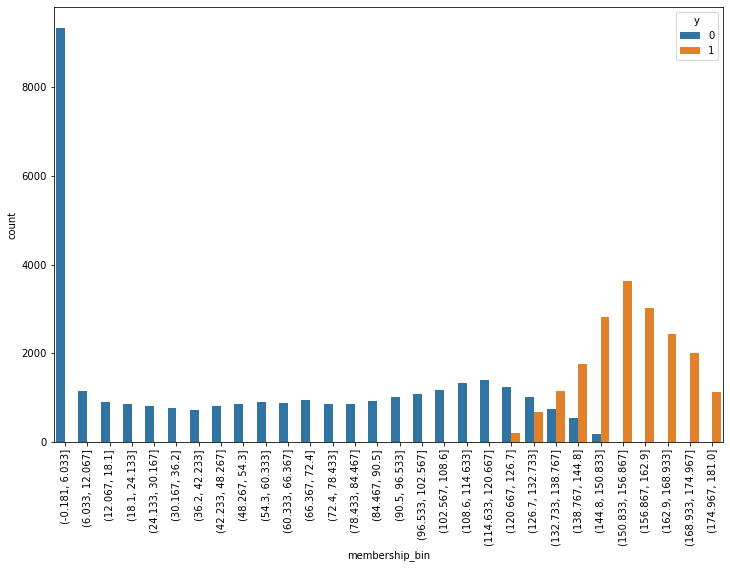

In [76]:
import pandas as pd

# Assuming df_ultimat['length_of_membership'] is a numerical column you want to bin
df_ultimat['membership_bin'] = pd.cut(df_ultimat['length_of_membership'], bins=30)

plt.figure(figsize=(12, 8))  # Increase figure size

# Now plot the binned data
ax = sns.countplot(x='membership_bin', hue='y', data=df_ultimat)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate the labels for better readability

plt.show()


## Observations:
- The shortest membership lengths, represented by the first bin, have a high count for 'y=0' and a lower count for 'y=1'.
- There is a noticeable increase in the count of 'y=1' active users as the membership length increases.
- The longest membership lengths show a dominant count for 'y=1' users, indicating that users with longer memberships are more likely to be active.

## Implications:
- The data suggests a positive correlation between the length of membership and user activity, with longer memberships being more likely to correspond to active users.
- This trend implies that as members stay with the service or program longer, their likelihood of remaining active increases.
- The low count of active users in the shortest membership length category could indicate a period of acclimation before members become active or could reflect a recent influx of new sign-ups.

## Potential Next Steps in Analysis:
- Investigate the causality behind longer memberships correlating with higher activity.
- Examine membership renewal rates and their relation to user activity.
- Determine if targeted engagement strategies for newer members could increase their activity levels more rapidly.

## Conclusion:
The histogram demonstrates that the length of membership is a significant indicator of user activity, with longer memberships more frequently associated with active users ('y=1').